In [149]:
import matplotlib.pyplot as plt
import numpy as np
from sys import platform
import itertools
if platform == 'linux':
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  try:
    os.chdir('drive/MyDrive/HP Laptop/funny_mps')
  except:
    pass
TI = np.loadtxt('ti_strebelle.dat', skiprows = 3)
TI = TI.reshape(250,250,1)

In [150]:
# define global parameters such as facies ratio, number of realizations, random seed, etc.
random_seed = 77777
n_real = 1
real_nx, real_ny, real_nz = 50, 50, 1
template_size = [3, 3, 1] # in x-, y-, and z- directions (odd number for better performance)
unique_facies = list(np.unique(TI))
facies_ratio = [np.sum(TI==f)/np.prod(TI.shape) for f in unique_facies]

TI_x, TI_y, TI_z = TI.shape
padding_x, padding_y, padding_z = int((template_size[0]-1)/2), int((template_size[1]-1)/2), int((template_size[2]-1)/2)

center_index = int((np.prod(template_size)-1)/2)
flag = [i for i in range(np.prod(template_size)) if i != center_index]

In [151]:
def curate_training_image(TI: np.ndarray, template_size: list[int]):
    # define the training image size and template size
    TI_x, TI_y, TI_z = TI.shape
    padding_x, padding_y, padding_z = int((template_size[0]-1)/2), int((template_size[1]-1)/2), int((template_size[2]-1)/2)
    
    # extract the training image to make a tabular form data
    x_0, x_1 = int(0 +padding_x), int(TI_x - padding_x)
    y_0, y_1 = int(0 +padding_y), int(TI_y - padding_y)
    z_0, z_1 = int(0 +padding_z), int(TI_z - padding_z)
    
    template_size_x, template_size_y, template_size_z = (x_1 - x_0), (y_1 - y_0), (z_1 - z_0)
    data = np.zeros((np.prod([template_size_x, template_size_y, template_size_y]), np.prod(template_size)))
    for zi, z  in enumerate(range(z_0, z_1)):
        for yi, y  in enumerate(range(y_0, y_1)):
            for xi, x in enumerate(range(x_0, x_1)):
                for i, [tx, ty, tz] in enumerate(itertools.product(range(template_size[0]),
                                                                range(template_size[1]),
                                                                range(template_size[2]))):
                    data[xi + yi*template_size_x + zi*template_size_x*template_size_y, i] = TI[x-(tx+padding_x), y-(ty+padding_y), z-(tz+padding_z)]

    # train some ML model the above tabular data
    center_index = int((np.prod(template_size)-1)/2)
    flag = [i for i in range(np.prod(template_size)) if i != center_index]
    data_x = data[:, flag].reshape(-1, np.prod(template_size)-1)
    data_y = data[:, center_index].reshape(-1, 1)

    return data_x, data_y

In [207]:
data_x, data_y = curate_training_image(TI, template_size)

In [208]:
# TODO: generate model
realization = np.ones((real_nx+2*padding_x, real_ny+2*padding_x, real_nz+2*padding_z))*-1
x_0, x_1 = int(0 +padding_x), int(realization.shape[0] - padding_x)
y_0, y_1 = int(0 +padding_y), int(realization.shape[1] - padding_y)
z_0, z_1 = int(0 +padding_z), int(realization.shape[2] - padding_z)
xx, yy, zz = np.meshgrid(range(x_0, x_1), range(y_0, y_1), range(z_0, z_1))
random_path = np.array([i.flatten() for i in [xx, yy, zz]])
np.random.seed(random_seed)
np.random.shuffle(random_path.T)

In [ ]:
import numpy as np

def get_valid_indices(input_x):
    """Returns the indices of non-missing values in input_x."""
    return np.where(input_x != -1)[1]

def filter_data(input_x, indices):
    """Filters input_x and data_x using valid indices."""
    return data_x[:, indices], input_x[:, indices]

def compute_facies_probabilities(data_x_new, input_x):
    """Computes the probability distribution for facies selection."""
    mask = np.all(data_x_new == input_x, axis=1)
    counts = np.bincount(data_y[mask], minlength=len(unique_facies))
    return counts / np.sum(counts) if np.sum(counts) > 0 else facies_ratio

def predictive_model(input_x):
    """Predicts the facies category based on input_x."""
    if np.all(input_x == -1):
        return np.random.choice(unique_facies, p=facies_ratio)1
    
    valid_indices = get_valid_indices(input_x)
    data_x_new, input_x_filtered = filter_data(input_x, valid_indices)
    probabilities = compute_facies_probabilities(data_x_new, input_x_filtered)
    
    return np.random.choice(unique_facies, p=probabilities)


In [210]:
from tqdm import tqdm
def predictive_model(input_x:np.array) -> float:
    if np.all(input_x == -1):
        return np.random.choice(unique_facies, p=facies_ratio)
    else:
        data_x_new = data_x[:, np.where(input_x!=-1)[1]]
        input_x = input_x[:,np.where(input_x!=-1)[1]]
        counts = np.array([(data_y[np.all(data_x_new==input_x, axis = 1)] == i).sum() for i in unique_facies])
        return np.random.choice(unique_facies, p=counts/np.sum(counts))
for ii, jj, kk in tqdm(zip(random_path[0].T, random_path[1].T, random_path[2].T)):
    template = realization[ii-padding_x:ii+(padding_x+1),
                           jj-padding_y:jj+(padding_y+1),
                           kk-padding_z:kk+(padding_z+1)].copy().flatten()
    input_x = template[flag].reshape(1,-1)  
    realization[ii, jj, kk] = predictive_model(input_x)
  

1274it [09:01,  2.35it/s]


KeyboardInterrupt: 

In [203]:
import numpy as np

def get_valid_indices(input_x):
    """Returns the indices of non-missing values in input_x."""
    return np.where(input_x != -1)[1]

def filter_data(input_x, indices):
    """Filters input_x and data_x using valid indices."""
    return data_x[:, indices], input_x[:, indices]

def compute_facies_probabilities(data_x_new, input_x):
    """Computes the probability distribution for facies selection."""
    mask = np.all(data_x_new == input_x, axis=1)
    counts = np.bincount(data_y[mask], minlength=len(unique_facies))
    return counts / np.sum(counts) if np.sum(counts) > 0 else facies_ratio

def predictive_model(input_x):
    """Predicts the facies category based on input_x."""
    if np.all(input_x == -1):
        return np.random.choice(unique_facies, p=facies_ratio)1
    
    valid_indices = get_valid_indices(input_x)
    data_x_new, input_x_filtered = filter_data(input_x, valid_indices)
    probabilities = compute_facies_probabilities(data_x_new, input_x_filtered)
    
    return np.random.choice(unique_facies, p=probabilities)

for ii, jj, kk in tqdm(zip(random_path[0].T, random_path[1].T, random_path[2].T)):
    template = realization[ii-padding_x:ii+(padding_x+1),
                           jj-padding_y:jj+(padding_y+1),
                           kk-padding_z:kk+(padding_z+1)].copy().flatten()
    input_x = template[flag].reshape(1,-1)  
    realization[ii, jj, kk] = predictive_model(input_x)


0it [00:00, ?it/s]


ValueError: object too deep for desired array

In [211]:
realization = realization[padding_x:realization.shape[0]-padding_x, padding_y:realization.shape[1]-padding_y, padding_z:realization.shape[2]-padding_z]

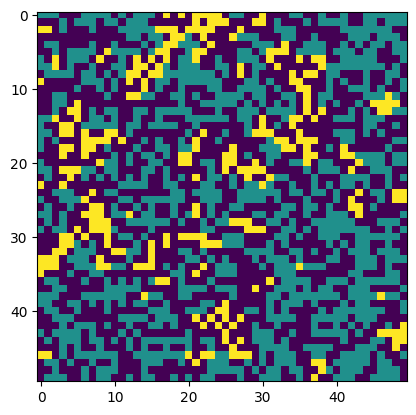

In [212]:
plt.imshow(realization.squeeze())

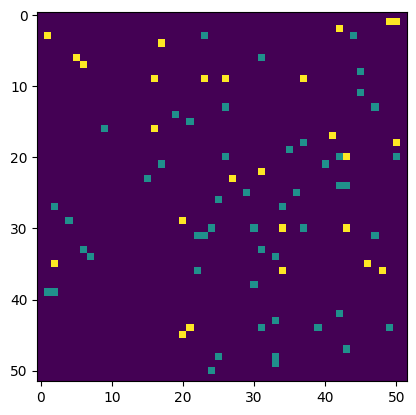

In [ ]:
random_path.shape

(3, 10000)